# California Housing Predictions
## Problem Description
The data may be found <a href="https://github.com/ageron/handson-ml/tree/master/datasets/housing">here</a>. An explanation directly from the GitHub site:

"This dataset appeared in a 1997 paper titled Sparse Spatial Autoregressions by Pace, R. Kelley and Ronald Barry, published in the Statistics and Probability Letters journal. They built it using the 1990 California census data. It contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people)."

## Table of Contents

1. [Data exploration](#data_exploration)
    1. [Initial impressions](#impressions)
    2. [Plots and Correlations](#plots)
2. [Analysis Pipeline](#pipeline)
    1. [Models and Cross-Validation](#ModelsCV)
    2. [Summary prior to Optimization](#priorsummary)
    3. [Grid Search](#gridsearch)
    4. [Randomized Search](#randomizedsearch)
    5. [Summary](#summary)
3. [Test Data](#testdata)

In [395]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
# Processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Validation

In [396]:
full = pd.read_csv('housing.csv')
train, test = train_test_split(full, test_size=0.2, random_state=42)
print('train size =', len(train), '\ntest size =', len(test))
print('full size =', len(train)+len(test), '\nchecking full', len(full) )

train size = 16512 
test size = 4128
full size = 20640 
checking full 20640


## Data exploration <a class="anchor" id="data_exploration"></a>

In [397]:
full.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND


In [398]:
full.shape

(20640, 10)

In [399]:
full.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [400]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [401]:
full.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [402]:
full.describe(include='O')

,ocean_proximity
count,20640
unique,5
top,<1H OCEAN
freq,9136


In [403]:
full['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

## Impressions <a class="anchor" id="impressions"></a>
1. 20640 entries, 10 features
2. ocean_proximity needs to be handled correctly, which includes converting it to an integer using some encoder method
3. total_bedrooms has some missing values, therefore we need to fill them with an appropriate method (most likely median)
4. Need to explore what drives meadian house value, let's plot data and look for correlations

## Plots and Correlations <a class="anchor" id="plots"></a>

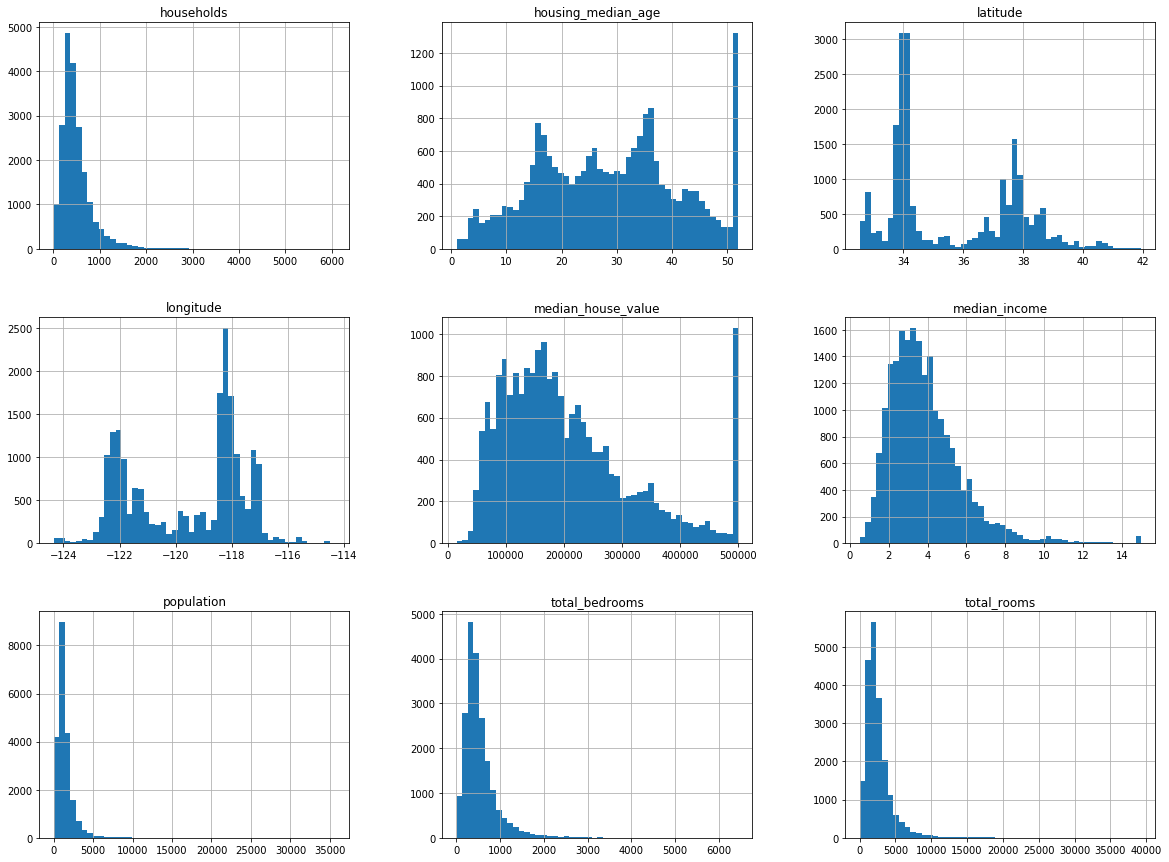

In [404]:
full.hist(bins=50, figsize=(20,15))
plt.show()

In [405]:
full['income_cat'] = np.ceil(full['median_income'] / 1.5)
# Note the where command only makes changes when the condition is false,
# hence the less than sign. Let's just assign anything >5 to cat 5
full['income_cat'].where(full['income_cat'] < 5, 5.0, inplace=True)

In [406]:
full.groupby(['income_cat'], as_index=False).size()

income_cat
1.0     822
2.0    6581
3.0    7236
4.0    3639
5.0    2362
dtype: int64

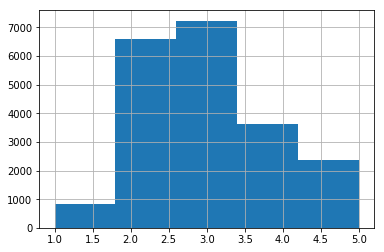

In [407]:
full['income_cat'].hist(bins=5)
plt.show()

In [408]:
# We know that median income is an important feature for this project
# Therefore, the income category proportions in the full data set should
# be similar to the test set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)
for train_index, test_index in split.split(full, full['income_cat']):
    strat_train_set = full.loc[train_index]
    strat_test_set = full.loc[test_index]

strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [409]:
# Now let's drop this new feature as we are done
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [410]:
# Let's work with the training set only
full = strat_train_set.copy()

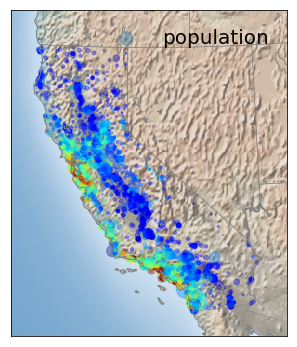

In [411]:
# While this plot is computationally expensive, it looks cool!
lat = full['latitude'].values
lon = full['longitude'].values
population = full['population'].values/100
value = full['median_house_value'].values

fig = plt.figure(figsize=(6,6))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=37.5, lon_0=-119,
            width=1.1E6, height=1.3E6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

m.scatter(lon, lat, latlon=True,
          c=value, s=population, label='population', 
          cmap=plt.get_cmap('jet'), alpha=0.35)
plt.legend(frameon=False,prop={'size':20})
plt.show()

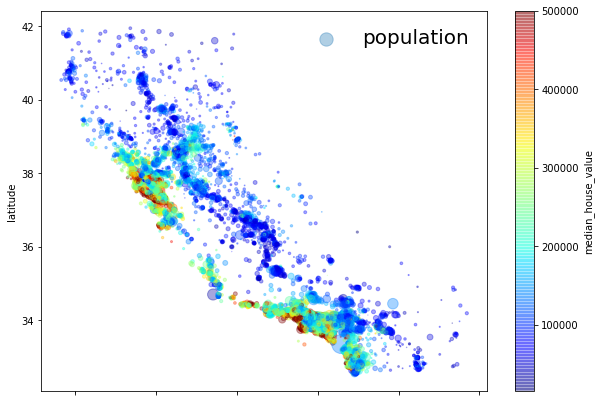

In [412]:
# Here is a faster variation of the above plot.
full.plot(kind='scatter', x='longitude', y='latitude', alpha=0.35,
         s=full['population']/100, label='population', 
         c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True,
         figsize=(10,7))
plt.legend(frameon=False, prop={'size':20})
plt.show()

#### Figures: The plots tells us what we already expected, namely that housing prices depend significantly on location. The circle size scales with population, and the color map displays the median house value

## Correlations

In [413]:
corr_matrix = full.corr()

In [414]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

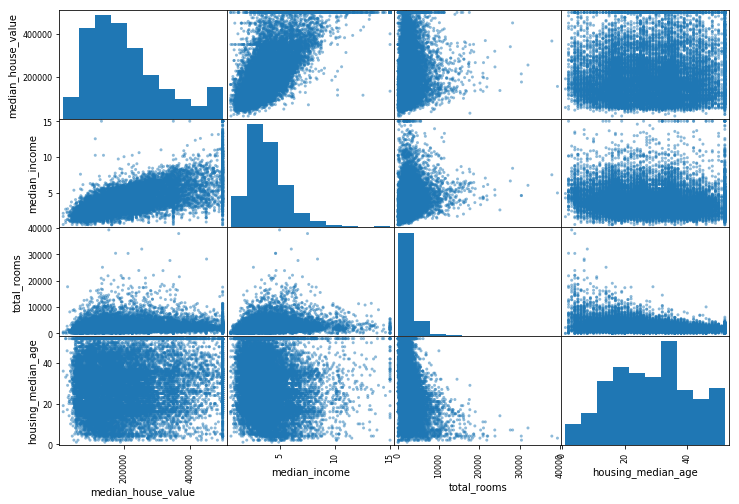

In [415]:
atts = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(full[atts], figsize=(12,8))
plt.show()

### Promising correlations between median_income and median_house_value; let's probe further

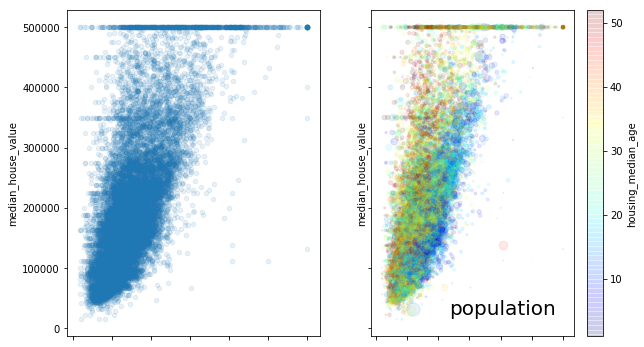

In [416]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharex=True, sharey=True)
full.plot(kind='scatter',x='median_income', y='median_house_value', 
          alpha=0.1, s=full['population']/100, label='population',
          c='housing_median_age',cmap=plt.get_cmap('jet'),ax=axes[1])
plt.legend(frameon=False, prop={'size':20},loc='lower right')

full.plot(kind='scatter',x='median_income', y='median_house_value', 
          alpha=0.1, ax=axes[0])
plt.show()

## There are some artificial effects, namely the horizontal bands at 500k, 450k, 350k, maybe 250k. May be related to binning/rounding within the census.

In [417]:
full['rooms_per_household'] = full['total_rooms'] / full['households']
full['bedrooms_per_room'] = full['total_bedrooms'] / full['total_rooms']
full['population_per_household'] = full['population'] / full['households']

In [418]:
corr_matrix = full.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

### We see that houses with a lower bedroom/room ratio tend to be more expensive; we see a positive correlation with the rooms_per_household variable, which is obvious.

In [419]:
full = strat_train_set.drop('median_house_value', axis=1)
full_labels = strat_train_set['median_house_value'].copy()

### Need to fix missing values in the total_bedrooms feature, which also propagates to the bedrooms_per_room feature. We have three options:
1. Remove the corresponding census blocks
2. Remove this feature
3. Replace empty spaces with the median or average. Average is not a good idea here since we have such large tails, and consequently the median is a better measure. We could also fit the distribution and randomly sample from it, which is probably the best method but requires more work.

In [420]:
# We will proceed with option 3)
# full.dropna(subset=['total_bedrooms']) #opt 1
# full.drop('total_bedrooms', axis=1)    #opt 2
median = full['total_bedrooms'].median()
print('Total bedroom median =', median)
full['total_bedrooms'].fillna(median, inplace=True)

Total bedroom median = 433.0


In [421]:
# Or we can use scikit's Imputer to handle this across all numeric features. This method
# is better if we are processing new/unseen data
#imputer = Imputer(strategy='median')
full_num = full.drop('ocean_proximity', axis=1) # imputer expects numerical features
#imputer.fit(full_num)
#imputer.statistics_
#X = imputer.transform(full_num) # replace missing values
#now put it back into the data frame
#full_tr = pd.DataFrame(X, columns=full_num.columns)

In [422]:
# Convert ocean_proximity feature to a number
full_cat = full['ocean_proximity']
full_cat_encoded, full_categories = full_cat.factorize() # map each feature to a diff int

# Pipeline <a class="anchor" id="pipeline"></a>

In [423]:
# Define a Transformer for flexibility
rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, bedrooms_ix] / X[:, rooms_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [424]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
full_extra_attribs = attr_adder.transform(full.values)

## Feature Scaling:
1. min-max scaling (normalization): subtract the min, then divide by max-min, which bounds the feature from 0 to 1.
2. standardization: subtract by the mean value, then divide by the variance so that the resulting distribution has unit variance. This technique does not bound the feature to a specific range, like min-max scaling. Also, this method is less affected by outliers, which in our case may be an issue.

## Transformation Pipelines - let's handle all of the above in the correct order

In [425]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [452]:
num_attribs = list(full_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector',      DataFrameSelector(num_attribs)),
        ('imputer',       Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler',    StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector',    DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

#full_num_tr = num_pipeline.fit_transform(full_num)

/home/freddy/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [453]:
full_prepared = full_pipeline.fit_transform(full)

In [454]:
print(full_prepared, '\n', full_prepared.shape)

[[-1.15604281  0.77194962  0.74333089 ...,  0.          0.          0.        ]
 [-1.17602483  0.6596948  -1.1653172  ...,  0.          0.          0.        ]
 [ 1.18684903 -1.34218285  0.18664186 ...,  0.          0.          1.        ]
 ..., 
 [ 1.58648943 -0.72478134 -1.56295222 ...,  0.          0.          0.        ]
 [ 0.78221312 -0.85106801  0.18664186 ...,  0.          0.          0.        ]
 [-1.43579109  0.99645926  1.85670895 ...,  0.          1.          0.        ]] 
 (16512, 16)


## Model and Cross-Validation<a class="anchor" id="ModelsCV"></a>

In [429]:
model_means = {}
model_sigmas = {}
def display_scores(scores,model):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Std. Dev:", scores.std())
    model_means[model] = scores.mean()
    model_sigmas[model] = scores.std()

### Linear Regression

In [430]:
lin_reg = LinearRegression()
lin_reg.fit(full_prepared, full_labels)
full_predictions = lin_reg.predict(full_prepared)
lin_mse = mean_squared_error(full_labels, full_predictions)
lin_rmse = np.sqrt(lin_mse)
print("MSE  =", lin_mse, "\nRMSE =", lin_rmse)
lin_mae = mean_absolute_error(full_labels, full_predictions)
print("MAE =", lin_mae)

MSE  = 4731795863.7 
RMSE = 68788.0502973
MAE = 49764.7593871


In [431]:
scores = cross_val_score(lin_reg, full_prepared, full_labels,
                        scoring='neg_mean_squared_error', cv=10)
lin_reg_rmse_scores = np.sqrt(-scores)
display_scores(lin_reg_rmse_scores, 'LinearReg')

Scores: [ 66866.67717061  67050.56185069  68885.38096155  74418.64270715
  68381.42262632  71362.77638618  65071.59178718  68485.70406531
  71370.74926727  67930.40194958]
Mean: 68982.3908772
Std. Dev: 2571.96101415


### Decision Tree

In [432]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(full_prepared, full_labels)
full_predictions = tree_reg.predict(full_prepared)
tree_mse = mean_squared_error(full_labels, full_predictions)
tree_rmse = np.sqrt(tree_mse)
print("MSE  =", tree_mse, "\nRMSE =", tree_rmse)

MSE  = 0.0 
RMSE = 0.0


In [433]:
scores = cross_val_score(tree_reg, full_prepared, full_labels,
                        scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores,'DecTree')

Scores: [ 70504.44106387  65321.0942038   73901.1139106   69777.89433383
  70809.55998501  73103.74164546  71358.88898625  71076.99231382
  69664.63034989  68405.86123398]
Mean: 70392.4218027
Std. Dev: 2276.4783042


### Random Forest

In [434]:
# Let's check Random Forest
forest_reg = RandomForestRegressor()
forest_reg.fit(full_prepared, full_labels)
full_predictions = forest_reg.predict(full_prepared)
forest_mse = mean_squared_error(full_labels, full_predictions)
forest_rmse = np.sqrt(forest_mse)
print("MSE  =", forest_mse, "\nRMSE =", forest_rmse)

/home/freddy/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


MSE  = 495931444.501 
RMSE = 22269.5182817


In [435]:
scores = cross_val_score(forest_reg, full_prepared, full_labels,
                        scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores,'RanForest')

Scores: [ 50412.50640222  48280.43222829  52139.33345724  54056.06535363
  52657.99026531  54932.66208041  51549.98315841  54427.86380391
  52684.07279074  52736.02025087]
Mean: 52387.6929791
Std. Dev: 1877.21223333


### Support Vector Regression

In [436]:
# Let's check SVR
svr = SVR(kernel='linear')
svr.fit(full_prepared, full_labels)
full_predictions = svr.predict(full_prepared)
svr_mse = mean_squared_error(full_labels, full_predictions)
svr_rmse = np.sqrt(svr_mse)
print("MSE  =", svr_mse, "\nRMSE =", svr_rmse)

MSE  = 12272613157.6 
RMSE = 110781.826838


In [437]:
scores = cross_val_score(svr, full_prepared, full_labels,
                        scoring='neg_mean_squared_error', cv=10)
svr_rmse_scores = np.sqrt(-scores)
display_scores(svr_rmse_scores, 'SVR')

Scores: [ 105119.10162187  112147.41649234  109840.1590787   112987.65440344
  110282.03151096  115319.07483997  110269.09698115  114128.48370504
  113408.15513584  111160.79643779]
Mean: 111466.197021
Std. Dev: 2726.5494146


## Summary prior to hyperparameter optimization <a class="anchor" id="priorsummary"></a>

LinearReg:
mean +/- sig = 68982.39 +/- 2571.96
DecTree:
mean +/- sig = 70392.42 +/- 2276.48
RanForest:
mean +/- sig = 52387.69 +/- 1877.21
SVR:
mean +/- sig = 111466.20 +/- 2726.55

Best model is RanForest


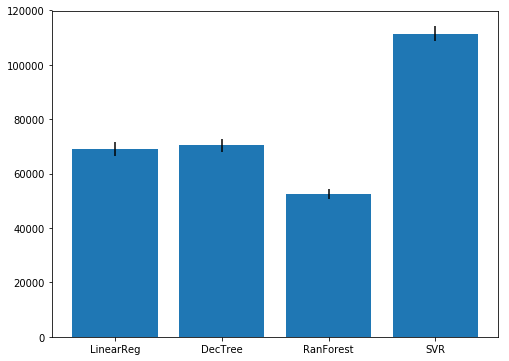

In [438]:
def model_summary():
    for key,val in model_means.items():
        print(key+":")
        print("mean +/- sig = %1.2f +/- %1.2f"  % (val, model_sigmas[key]))
    print("\nBest model is", min(model_means, key=model_means.get))
    # Plot the mean score, assign the error in y as the std dev
    fig, ax = plt.subplots(figsize=(8,6))
    plt.bar(range(len(model_means)), model_means.values(), 
            yerr=model_sigmas.values(), linestyle=None)
    plt.xticks(range(len(model_means)), model_means.keys())
    plt.show()
model_summary()

### Random forest yields best value, let's optimize

# GridSearch <a class="anchor" id="gridsearch"></a>

In [439]:
from sklearn.model_selection import GridSearchCV

In [440]:
param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [2,4,6,8]},
    {'bootstrap':[False], 'n_estimators': [3,10], 
     'max_features' : [2, 3, 4]}
]

In [441]:
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, 
                          scoring='neg_mean_squared_error')
grid_search.fit(full_prepared, full_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [442]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [443]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

66559.3082324 {'max_features': 2, 'n_estimators': 3}
58845.5920304 {'max_features': 2, 'n_estimators': 10}
55583.7666423 {'max_features': 2, 'n_estimators': 30}
62674.4063147 {'max_features': 4, 'n_estimators': 3}
55337.9928281 {'max_features': 4, 'n_estimators': 10}
52807.5746874 {'max_features': 4, 'n_estimators': 30}
62697.5178647 {'max_features': 6, 'n_estimators': 3}
54341.4299157 {'max_features': 6, 'n_estimators': 10}
51928.9004674 {'max_features': 6, 'n_estimators': 30}
60767.0828772 {'max_features': 8, 'n_estimators': 3}
53971.9402828 {'max_features': 8, 'n_estimators': 10}
51404.8801969 {'max_features': 8, 'n_estimators': 30}
64051.9538087 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
57064.0940208 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
62817.1824581 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
55295.9210565 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
61333.1861768 {'bootstrap': False, 'max_features': 4, 'n_estim

### GridSearch only yields minor improvements, most likely because I did not scan the hyperparameter region with fine enough granularity (but we get the point)

## RandomizedSearch <a class="anchor" id="randomizedsearch"></a>

In [444]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [445]:
forest_reg_1 = RandomForestRegressor()
param_dist = {"n_estimators": sp_randint(4,30),
              "max_depth": [3, None],
              "max_features": sp_randint(4, 15),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False]}
random_search = RandomizedSearchCV(forest_reg_1, 
                                   param_distributions=param_dist,
                                   n_iter=100, cv=5)

In [446]:
# This calculation takes awhile, comment out
# random_search.fit(full_prepared, full_labels)

In [447]:
# # Utility function to report best scores
# def report(results, n_top=3):
#     for i in range(1, n_top + 1):
#         candidates = np.flatnonzero(results['rank_test_score'] == i)
#         for candidate in candidates:
#             print("Model with rank: {0}".format(i))
#             print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
#                   results['mean_test_score'][candidate],
#                   results['std_test_score'][candidate]))
#             print("Parameters: {0}".format(results['params'][candidate]))
#             print("")

In [448]:
#report(random_search.cv_results_)

## Use the found parameters to define a RF

In [449]:
forest_reg_RSCV = RandomForestRegressor(n_estimators=25,
                                       bootstrap=False, max_depth=None,
                                       max_features=10, 
                                        min_samples_split=10)
forest_reg_RSCV.fit(full_prepared, full_labels)
full_predictions = forest_reg_RSCV.predict(full_prepared)
forest_mse_RSCV = mean_squared_error(full_labels, full_predictions)
forest_rmse_RSCV = np.sqrt(forest_mse_RSCV)
print("MSE  =", forest_mse_RSCV, "\nRMSE =", forest_rmse_RSCV)

MSE  = 259376284.039 
RMSE = 16105.1632726


In [450]:
scores = cross_val_score(forest_reg_RSCV, full_prepared, full_labels,
                        scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores_RSCV = np.sqrt(-scores)
display_scores(forest_rmse_scores_RSCV, 'RanForestOpt')

Scores: [ 47968.76844446  47266.25197848  50634.78972102  52151.48120164
  49088.50408648  52806.38448868  48782.34679468  50869.71677196
  52960.37549747  50199.47807523]
Mean: 50272.809706
Std. Dev: 1887.75469144


## Here we have an improvement, let's compare <a class="anchor" id="summary"></a>

LinearReg:
mean +/- sig = 68982.39 +/- 2571.96
DecTree:
mean +/- sig = 70392.42 +/- 2276.48
RanForest:
mean +/- sig = 52387.69 +/- 1877.21
SVR:
mean +/- sig = 111466.20 +/- 2726.55
RanForestOpt:
mean +/- sig = 50272.81 +/- 1887.75

Best model is RanForestOpt


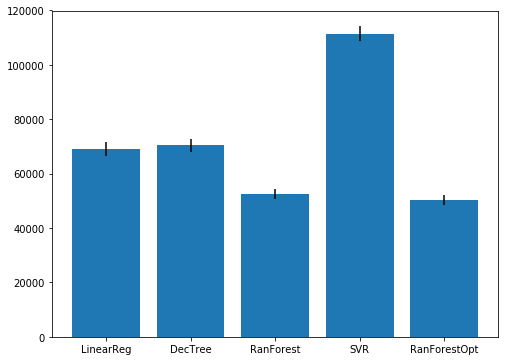

In [451]:
model_summary()

## Evaluate the Test Data <a class="anchor" id="testdata"></a>

In [457]:
X_test = strat_test_set.drop('median_house_value',axis=1)
y_test = strat_test_set['median_house_value'].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = forest_reg_RSCV.predict(X_test_prepared)
final_mse  = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print("MSE  =", final_mse, "\nRMSE =", final_rmse)

MSE  = 2324147122.63 
RMSE = 48209.4090674


### We've learned that with the data set at hand, the median income is the number one predictor of housing prices